In [25]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [26]:
alldat = scipy.io.loadmat('behavDat_collated_Nov04.mat')
alldat = alldat['alldat']

In [27]:
# for sub 7, 30, 40
dat = np.copy(np.vstack((alldat[:,7][0],
                         alldat[:,29][0],
                         alldat[:,39][0])))
dat.shape

(1080, 7)

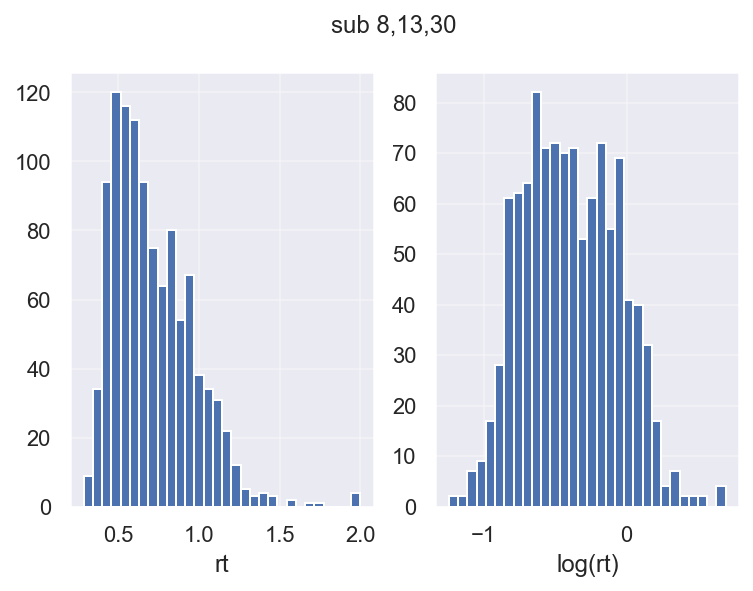

In [28]:
fig, axes = plt.subplots(1, 2)
# hist
axes[0].grid(True, alpha = .3);
axes[0].hist(dat[dat[:,3]>.25, 3], 30);
axes[0].set_xlabel('rt'); 
# log normal
axes[1].grid(True, alpha = .3);
axes[1].hist(np.log(dat[dat[:,3]>.25, 3]), 30);
axes[1].set_xlabel('log(rt)'); 

fig.suptitle('sub 8,13,30');

In [29]:
# reduce offer 
off = np.copy(dat[:,1])
off[dat[:,1]<25] = 2
off[(dat[:,1]>=25) & (dat[:,1]<35)] = 3
off[(dat[:,1]>=35) & (dat[:,1]<45)] = 4

# resp should be 0 and 1
dat[:,-1] = (dat[:,-1]+1)/2

off.shape

(1080,)

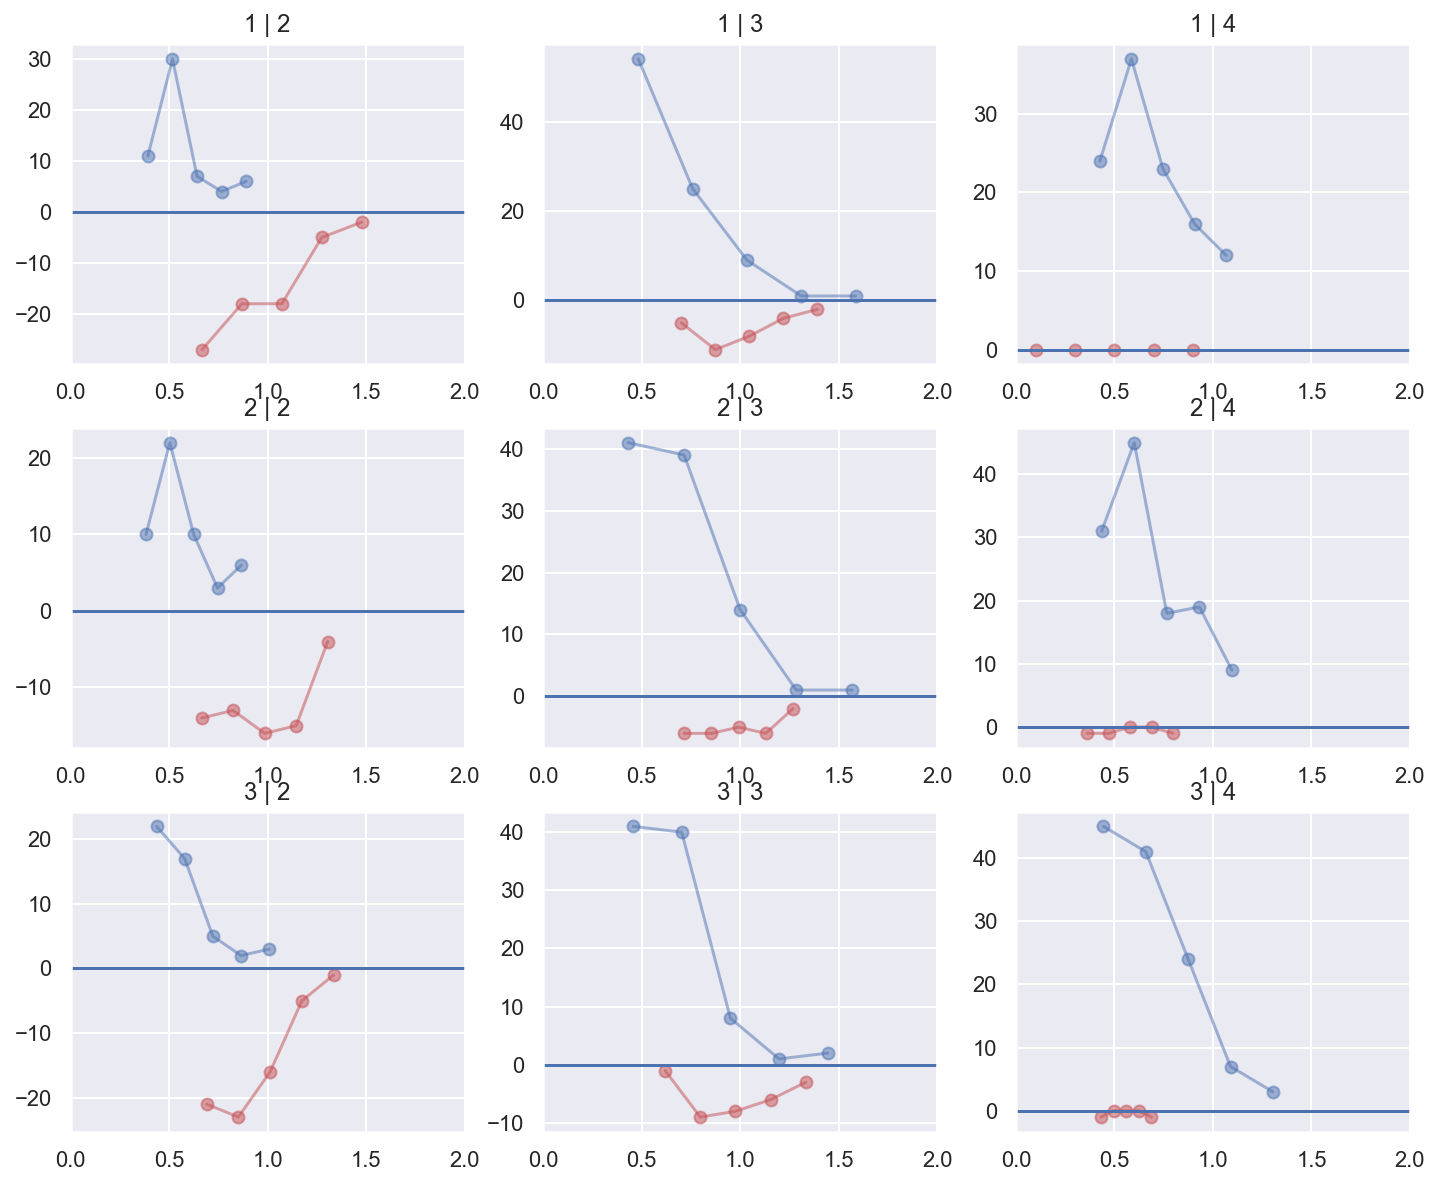

In [30]:
plt.figure(figsize = (12, 10))
k = 1
for emot_idx in [1, 2, 3]:
    for off_idx in [2, 3, 4]:
        slice_idx = (dat[:,0]==emot_idx) & (off==off_idx) & (dat[:,3] > .25) & (dat[:,3] != 2)
        rt1 = np.copy(dat[slice_idx & (dat[:,-1]==1), 3])
        rt0 = np.copy(dat[slice_idx & (dat[:,-1]==0), 3])
        
        [freq1, bins1] = np.histogram(rt1, 5)
        bins1 = [(bins1[k]+bins1[k+1])/2 for k in range(len(bins1)-1)]
        [freq0, bins0] = np.histogram(rt0, 5)
        bins0 = [(bins0[k]+bins0[k+1])/2 for k in range(len(bins0)-1)]
        
        plt.subplot(3, 3, k)
        plt.plot(bins1, freq1, 'bo-', alpha = .5)
        plt.plot(bins0, -freq0, 'ro-', alpha = .5)
        plt.xlim([0, 2]); 
        plt.title("{} | {}".format(emot_idx, off_idx))
        plt.axhline(0)
        k += 1;

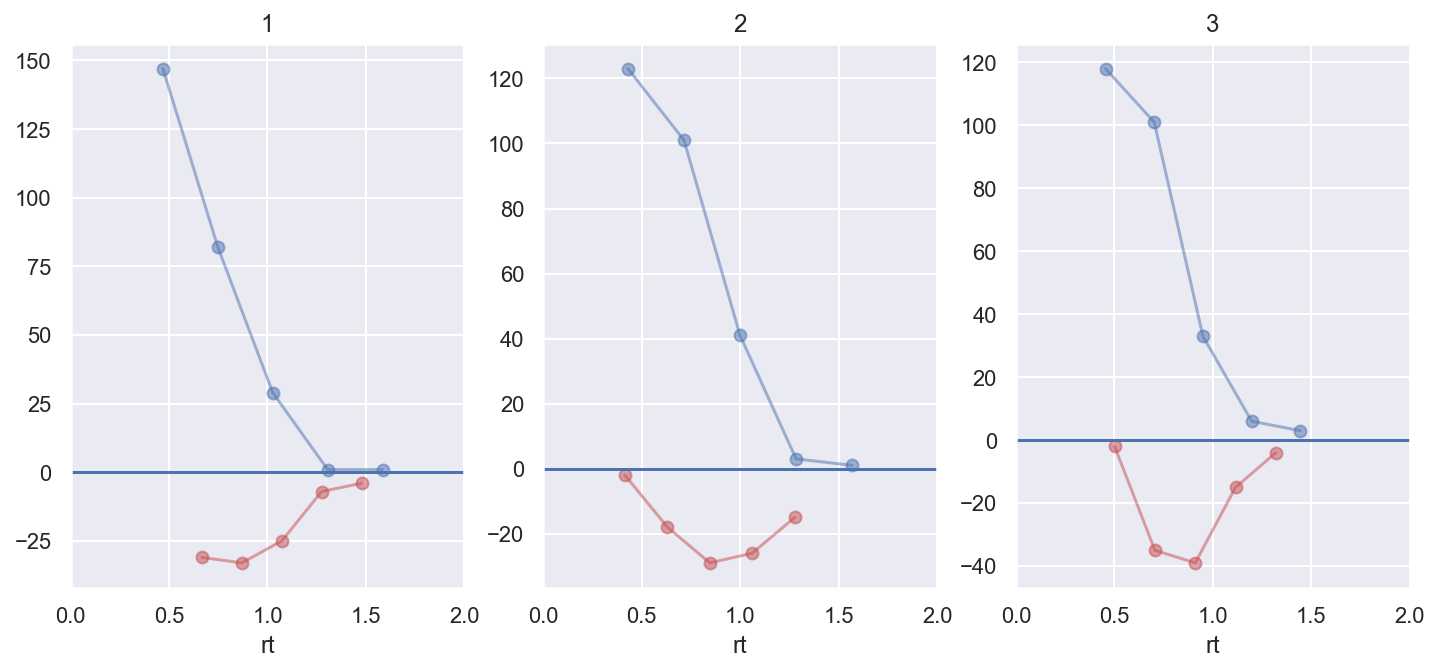

In [31]:
plt.figure(figsize = (12, 5))
k = 1
for emot_idx in [1, 2, 3]:
    slice_idx = (dat[:,0]==emot_idx) & (dat[:,3] > .25) & (dat[:,3] != 2)
    rt1 = np.copy(dat[slice_idx & (dat[:,-1]==1), 3])
    rt0 = np.copy(dat[slice_idx & (dat[:,-1]==0), 3])

    [freq1, bins1] = np.histogram(rt1, 5)
    bins1 = [(bins1[k]+bins1[k+1])/2 for k in range(len(bins1)-1)]
    [freq0, bins0] = np.histogram(rt0, 5)
    bins0 = [(bins0[k]+bins0[k+1])/2 for k in range(len(bins0)-1)]

    plt.subplot(1, 3, k)
    plt.plot(bins1, freq1, 'bo-', alpha = .5)
    plt.plot(bins0, -freq0, 'ro-', alpha = .5)
    plt.xlim([0, 2]); 
    plt.xlabel("rt"); plt.title(emot_idx)
    plt.axhline(0)
    k += 1;

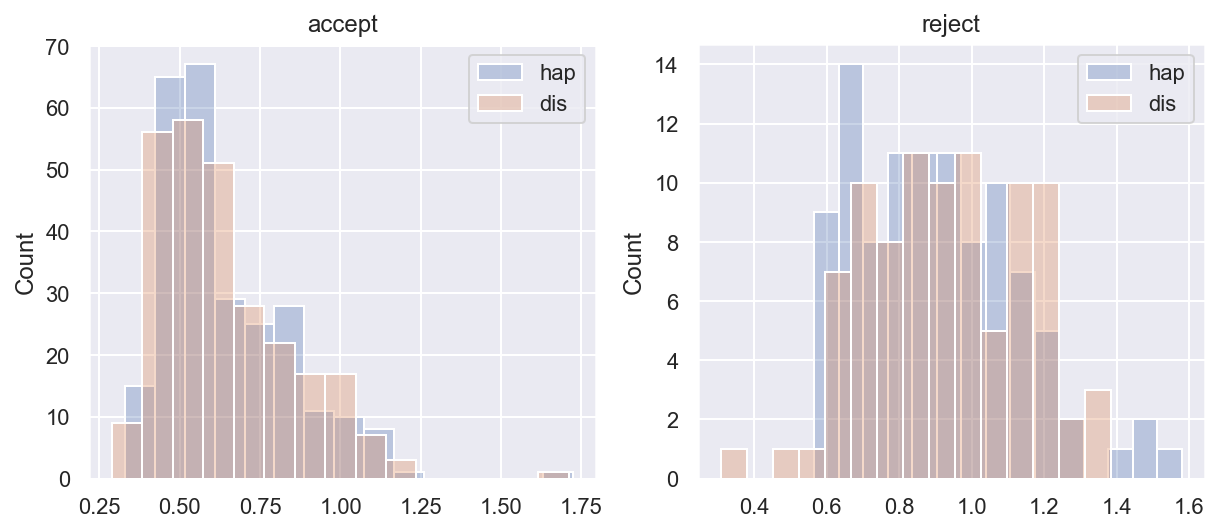

In [32]:
from numpy import log
plt.figure(figsize = (10,4))
for emot_idx in [1, 2]:
    plt.subplot(1, 2, 1)
    sns.histplot((dat[(dat[:,0]==emot_idx) & (dat[:,3] > .25) & (dat[:,-1]==1), 3]), bins = 15, alpha = .3);
    plt.title("accept"); plt.legend(["hap", "dis", "neu"])
    
    plt.subplot(1, 2, 2)
    sns.histplot((dat[(dat[:,0]==emot_idx) & (dat[:,3] > .25) & (dat[:,-1]==0), 3]), bins = 15, alpha = .3);
    plt.title("reject"); plt.legend(["hap", "dis", "neu"])

In [33]:
import ddm
from ddm import Sample
from ddm import Model, Fittable
from ddm.functions import fit_adjust_model, display_model
from ddm.models import (NoiseConstant, BoundCollapsingExponential, 
                        OverlayChain,OverlayNonDecision,OverlayPoissonMixture)

# define drift
class DriftCoherence(ddm.models.Drift):
    name = "drift depends linearly on offer size"
    required_parameters = ["driftoff"] 
    required_conditions = ["off"] 
    
    def get_drift(self, conditions, **kwargs):
        return self.driftoff * conditions['off'] 

class ICPointRatio(ddm.models.InitialCondition):
    name = "an arbitrary starting point expressed as a proportion of the distance between the bounds."
    required_parameters = ["x0"]
    
    def get_IC(self, x, dx, conditions):
        x0 = self.x0/2 + .5 #rescale to between 0 and 1
        shift_i = int((len(x)-1)*x0)
        assert shift_i >= 0 and shift_i < len(x), "Invalid initial conditions"
        pdf = np.zeros(len(x))
        pdf[shift_i] = 1.
        return pdf
    
# model
model = Model(name='behav data, drift varies with offer size',
                 drift=DriftCoherence(driftoff=Fittable(minval=-3, maxval=3)),
                 noise=NoiseConstant(noise=1),
                 IC=ICPointRatio(x0=Fittable(minval=-1, maxval=1)),
                 bound=BoundCollapsingExponential(B=1,
                                                  tau=Fittable(minval=.0001, maxval=5)),
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.005, dt=.01, T_dur=2)

# prep the data and fit the model
model_dict = {1: [], 2: [], 3: []}

for emot_idx in model_dict.keys():
    slice_idx = (dat[:,0]==emot_idx) & (dat[:,3] > .25) & (dat[:,3] != 2)
    tbl = np.vstack((np.copy(dat[slice_idx,3]), 
                    np.copy(dat[slice_idx,-1]), 
                    np.copy(dat[slice_idx,1])/dat[slice_idx,1].max())).transpose();
    conditions = ["off"];
    tbl = Sample.from_numpy_array(tbl, conditions)

    model_fit = fit_adjust_model(tbl, model, verbose=False)
    model_dict[emot_idx] = model_fit

KeyboardInterrupt: 

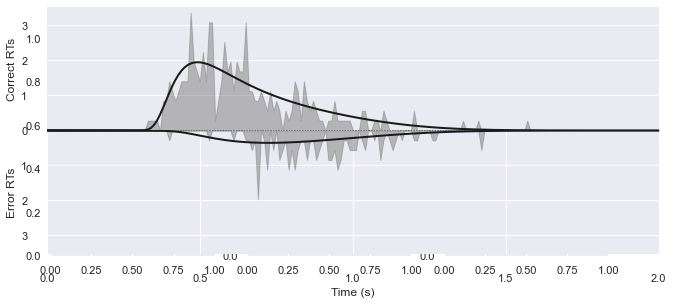

In [ ]:
plt.figure(figsize = (10, 4))

import ddm.plot
plt.subplot(1, 3, 1);
ddm.plot.plot_fit_diagnostics(model=model_dict[1], sample=tbl)

plt.subplot(1, 3, 2);
ddm.plot.plot_fit_diagnostics(model=model_dict[2], sample=tbl)

plt.subplot(1, 3, 3);
ddm.plot.plot_fit_diagnostics(model=model_dict[3], sample=tbl)

In [ ]:
display_model(model_dict[3])

NameError: name 'display_model' is not defined

# HSSM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import hssm

%matplotlib inline
%config InlineBackend.figure_format='retina'

hssm.set_floatX("float32")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [ ]:
import scipy.io
alldat = scipy.io.loadmat('behavDat_collated_Nov04.mat')
alldat = alldat['alldat']

In [ ]:
dataset_ddm = []
k = 0;
for sub_idx in range(40):
  dat = alldat[:,sub_idx][0]

  # skip for AA/AR
  accpt = sum(dat[:,-1]==1)/len(dat)
  if accpt > .95 or accpt < .05:
    print(sub_idx)

  else:
    # remove the missed trials
    dat = dat[dat[:,-1]!=0,:]
    # remove non-biological rt-s
    dat = dat[dat[:,3]>.3,:]
    dat = dat[dat[:,3]<
              np.percentile( dat[:,3],95)
              ,:]

    for iter_idx in range(len(dat)):
      trial = dat[iter_idx, :]
      dataset_ddm.append([trial[3],
                          trial[-1],
                          trial[0]-1,
                          trial[1],
                          k])
    k += 1

dataset_ddm = pd.DataFrame(dataset_ddm,
                           columns = ['rt', 'response',
                                      'emot', 'off', 'subject'])
# scale offer
temp = dataset_ddm['off'];
dataset_ddm['off'] = (temp - temp.min()) / (temp.max() - temp.min())

# add dummy variable for emotion
dataset_ddm = pd.concat([dataset_ddm,
                         pd.get_dummies(dataset_ddm["emot"])],
                         axis = 1)

dataset_ddm = dataset_ddm.drop([0.0], axis = 1)
dataset_ddm = dataset_ddm.rename(columns = {
                           'emot': 'emot_idx',
                           'off': 'off_norm',
                           1.0: 'emot_1',
                           2.0: 'emot_2'})
# keep the dummies as float
dataset_ddm[['emot_1', 'emot_2']] = dataset_ddm[['emot_1',
                                                 'emot_2']].astype(float)

dataset_ddm['emot_idx'] = dataset_ddm['emot_idx'].astype('category')

dataset_ddm

13
14
20
28
36
37
38


,rt,response,emot_idx,off_norm,subject,emot_1,emot_2
0,0.939806,1.0,1.0,0.275862,0,1.0,0.0
1,1.111123,1.0,1.0,0.517241,0,1.0,0.0
2,0.777563,1.0,2.0,0.689655,0,0.0,1.0
3,0.993828,1.0,2.0,0.620690,0,0.0,1.0
4,0.746867,1.0,1.0,0.931034,0,1.0,0.0
...,...,...,...,...,...,...,...
11167,0.517135,1.0,0.0,0.793103,32,0.0,0.0
11168,0.413505,1.0,1.0,0.965517,32,1.0,0.0
11169,0.500837,1.0,0.0,0.137931,32,0.0,0.0
11170,0.457372,1.0,0.0,0.896552,32,0.0,0.0


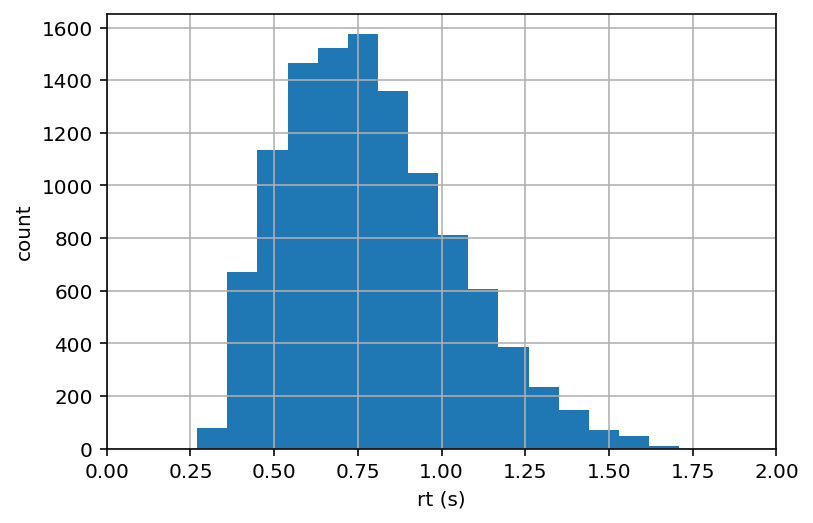

In [ ]:
plt.hist(dataset_ddm['rt'], np.arange(0,2,.09));
plt.xlabel('rt (s)'); plt.ylabel('count')
plt.xlim([0, 2])
plt.grid(1)

In [ ]:
model_ddm_array = [];

for i in range(1):
  model_ddm_array.append(hssm.HSSM(
      data = dataset_ddm,
      model = 'ddm',
      include=[
          {
              "name": "v",
              "prior": {
                  "Intercept": {"name": "Normal", "mu": 0.0, "sigma": 2.0},
                  "off_norm": {"name": "Normal", "mu": 0.0, "sigma": 2.0},
                  "emot_idx": {"name": "Normal", "mu": 0.0, "sigma": 2.0},
              },
              "formula": "v ~ (1|subject) + off_norm + emot_idx",
              "link": "identity",
          },
          # {
          #     "name": "z",
          #     "prior": {
          #         "Intercept": {"name": "Normal", "mu": 0.0, "sigma": 2.0},
          #         # "emot_idx": {"name": "Normal", "mu": 0.0, "sigma": 2.0},
          #     },
          #     "formula": "z ~ (1|subject)",
          #     "link": "identity",
          # },
          # {
          #     "name": "a",
          #     "prior": {
          #         "Intercept": {"name": "HalfNormal", "sigma": 2.0},
          #     },
          #     "formula": "a ~ (1|subject)",
          #     "link": "identity",
          # },
          # {
          #     "name": "t",
          #     "prior": {
          #         "Intercept": {"name": "HalfNormal", "sigma": 2.0},
          #     },
          #     "formula": "t ~ (1|subject)",
          #     "link": "identity",
          # }
      ],
  ))

In [34]:
model_ddm_array[0]

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 11172

Parameters:

v:
    Formula: v ~ (1|subject) + off_norm + emot_idx
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 2.0)
        v_off_norm ~ Normal(mu: 0.0, sigma: 2.0)
        v_emot_idx ~ Normal(mu: 0.0, sigma: 2.0)
        v_1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
    Link: identity
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

In [35]:
from numba import njit, jit, cuda 

In [44]:
#@jit(target_backend='cuda')
def run_ddm(model_ddm):
     for i in range(1):
          idat_ddm = model_ddm.sample(nuts_sampler="blackjax",
                                      chains=2,
                                      draws=500,
                                      tune=500,
                                      idata_kwargs=dict(
                                        log_likelihood=True),
                                        )
     return idat_ddm

idat_ddm = run_ddm(model_ddm_array[0])
model_ddm_array[0].summary()

d:\Python310\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(


ModuleNotFoundError: No module named 'blackjax'

In [10]:
from numba import njit, jit, cuda 
import numpy as np 
# to measure exec time 
from timeit import default_timer as timer 

# normal function to run on cpu 
def func(a):								 
	for i in range(10000000): 
		a[i]+= 1	

# function optimized to run on gpu 						 
@njit
def func2(a): 
	for i in range(10000000): 
		a[i]+= 1

@jit(target_backend='cuda')
def func3(a): 
	for i in range(10000000): 
		a[i]+= 1

if __name__=="__main__": 
	n = 100000000						
	a = np.ones(n, dtype = np.float64) 
	
	start = timer() 
	func(a) 
	print("without GPU:", timer()-start)	 
	
	start = timer() 
	func2(a) 
	print("with GPU:", timer()-start) 

	start = timer() 
	func3(a) 
	print("with CUDA GPU:", timer()-start) 

without GPU: 5.841753299988341
with GPU: 0.29779439998674206
with CUDA GPU: 0.4441919999953825
